In [11]:
##############################################
# 1) LOADING THE MODEL
##############################################
import torch
import yaml
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config


def load_vae_model(ckpt_path, config_path, device="cpu"):
    """
    Load a BasicAutoencoderKL (or similar) from a checkpoint and config.
    Returns the model on the given device, in eval mode.

    Args:
      ckpt_path: str, path to your .ckpt file
      config_path: str, path to your .yaml config
      device: str, e.g. "cpu", "cuda", or "mps"

    Returns:
      model: a torch.nn.Module with the loaded checkpoint
    """
    # Load config
    config = OmegaConf.load(config_path)
    model_config = config.model

    # Instantiate model from config
    model = instantiate_from_config(model_config)

    # Load checkpoint weights
    state = torch.load(ckpt_path, map_location="cpu")
    model.load_state_dict(state["state_dict"], strict=False)

    # Move model to device
    model = model.to(device)
    model.eval()

    return model


##############################################
# 2) LOADING & PREPARING A SINGLE IMAGE
##############################################
import pandas as pd
import numpy as np
import tifffile
import io
import boto3
from botocore.config import Config
from botocore import UNSIGNED


def load_cellpainting_image_from_df(
    df, row_index=0, channels=None, bucket_name="cellpainting-gallery"
):
    """
    Fetch a single multi-channel Cell Painting image from S3, convert to [-1,1] range.

    Args:
      df: pd.DataFrame, must contain columns like "Image_DNA", "Image_ER", etc.
      row_index: which row to load
      channels: list of str channel names, e.g. ["DNA", "ER", "RNA", "AGP", "Mito"]
      bucket_name: S3 bucket name (default "cellpainting-gallery")

    Returns:
      img_tensor: torch.Tensor of shape [1, C, H, W], in [-1,1], float32
      actual_channels: list of channels actually loaded (some might be missing)
    """
    if channels is None:
        # default channels
        channels = ["DNA", "ER", "RNA", "AGP", "Mito"]

    row = df.iloc[row_index]
    # print(f"Row {row_index} meta:\n{row.to_string()}\n")

    s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))

    images_16bit = []
    actual_channels = []
    for ch in channels:
        col = f"Image_{ch}"
        if col not in row or not isinstance(row[col], str):
            print(f"Skipping channel {ch}; no valid S3 path found.")
            continue
        s3_key = row[col]

        response = s3.get_object(Bucket=bucket_name, Key=s3_key)
        tif_data = response["Body"].read()
        img = tifffile.imread(io.BytesIO(tif_data))
        # Convert [0,65535] => [0,1]
        img_01 = (img.astype(np.float32) / 65535.0).clip(0, 1)

        images_16bit.append(img_01)
        actual_channels.append(ch)

    if not images_16bit:
        raise ValueError(f"No valid channels found in row {row_index}.")

    # Stack => shape (C,H,W)
    multi_channel = np.stack(images_16bit, axis=0)
    # Rescale [0,1] => [-1,1]
    multi_channel = (multi_channel * 2.0) - 1.0

    # Convert to torch
    img_tensor = torch.from_numpy(multi_channel).unsqueeze(0).float()  # [B=1,C,H,W]
    return img_tensor, actual_channels


##############################################
# 3) VISUALIZE: REAL VS. RECON BY CHANNEL
##############################################
import matplotlib.pyplot as plt


def show_channels_side_by_side(real, recon, channel_names=None):
    """
    real, recon: [C,H,W] in [-1,1] or np arrays. We'll clamp to [0,1] for display.
    channel_names: e.g. ["DNA","ER","RNA"]
    """
    if channel_names is None:
        channel_names = [f"ch{i}" for i in range(real.shape[0])]

    C, H, W = real.shape
    plt.figure(figsize=(4 * C, 6))

    # ensure CPU + numpy
    real_np = real.detach().cpu().numpy() if torch.is_tensor(real) else real
    recon_np = recon.detach().cpu().numpy() if torch.is_tensor(recon) else recon

    # map [-1,1] => [0,1]
    real_vis = (real_np * 0.5 + 0.5).clip(0, 1)
    recon_vis = (recon_np * 0.5 + 0.5).clip(0, 1)

    for c in range(C):
        ax1 = plt.subplot(2, C, c + 1)
        ax1.imshow(real_vis[c], cmap="gray")
        ax1.set_title(f"Real {channel_names[c]}")
        ax1.axis("off")

        ax2 = plt.subplot(2, C, C + c + 1)
        ax2.imshow(recon_vis[c], cmap="gray")
        ax2.set_title(f"Recon {channel_names[c]}")
        ax2.axis("off")

    plt.tight_layout()
    plt.show()


##############################################
# 4) VISUALIZE: LOG-VAR (PER CHANNEL + MEAN/MIN)
##############################################
import math


def visualize_logvar_full(
    model, img_tensor, figsize_channels=(12, 12), figsize_agg=(10, 4), cmap="magma"
):
    """
    1) Encode `img_tensor` => posterior.logvar [B,zC,H_z,W_z]
    2) Plot each channel of logvar in a grid
    3) Plot mean/min across channels => see any 'black hole'
    """
    model.eval()
    with torch.no_grad():
        posterior = model.encode(img_tensor)  # shape [B, zC, H_z, W_z]
        logvar = posterior.logvar

    # Just the first item
    logvar_1 = logvar[0].cpu().numpy()  # shape (zC,H_z,W_z)
    zC, H_z, W_z = logvar_1.shape

    # (A) Per-channel grid
    ncols = int(math.ceil(math.sqrt(zC)))
    nrows = int(math.ceil(zC / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize_channels)
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    axes = axes.flatten()

    for c in range(zC):
        ax = axes[c]
        ax.imshow(logvar_1[c], cmap=cmap)
        ax.set_title(f"logvar ch {c+1}")
        ax.axis("off")

    # Hide leftover
    for extra_ax in axes[zC:]:
        extra_ax.axis("off")

    plt.tight_layout()
    plt.show()

    # (B) Aggregated maps
    mean_logvar = logvar_1.mean(axis=0)
    min_logvar = logvar_1.min(axis=0)

    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize_agg)

    im1 = ax1.imshow(mean_logvar, cmap=cmap)
    ax1.set_title("Mean Log-Variance")
    ax1.axis("off")
    plt.colorbar(im1, ax=ax1, fraction=0.045)

    im2 = ax2.imshow(min_logvar, cmap=cmap)
    ax2.set_title("Min Log-Variance")
    ax2.axis("off")
    plt.colorbar(im2, ax=ax2, fraction=0.045)

    plt.tight_layout()
    plt.show()

making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
Working with z of shape (1, 64, 8, 8) = 4096 dimensions.
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels


/var/folders/3x/wb42gyq95ts03_70yq2vdc_h0000gn/T/ipykernel_56389/765131137.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="c

Loaded 752 rows.


making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
Working with z of shape (1, 64, 8, 8) = 4096 dimensions.
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 1024 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels
making attention of type 'vanilla' with 512 in_channels


/var/folders/3x/wb42gyq95ts03_70yq2vdc_h0000gn/T/ipykernel_56389/765131137.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_path, map_location="c

Loaded 752 rows.


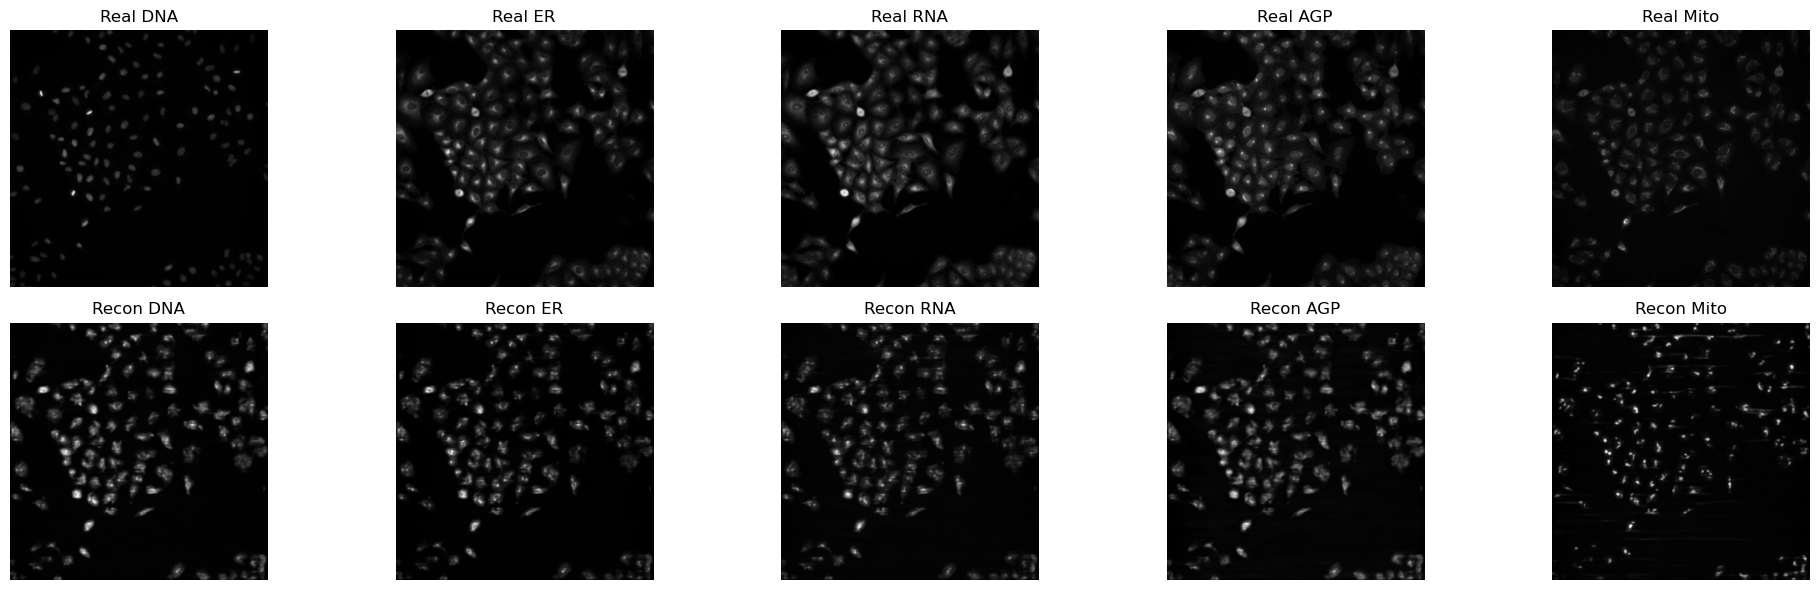

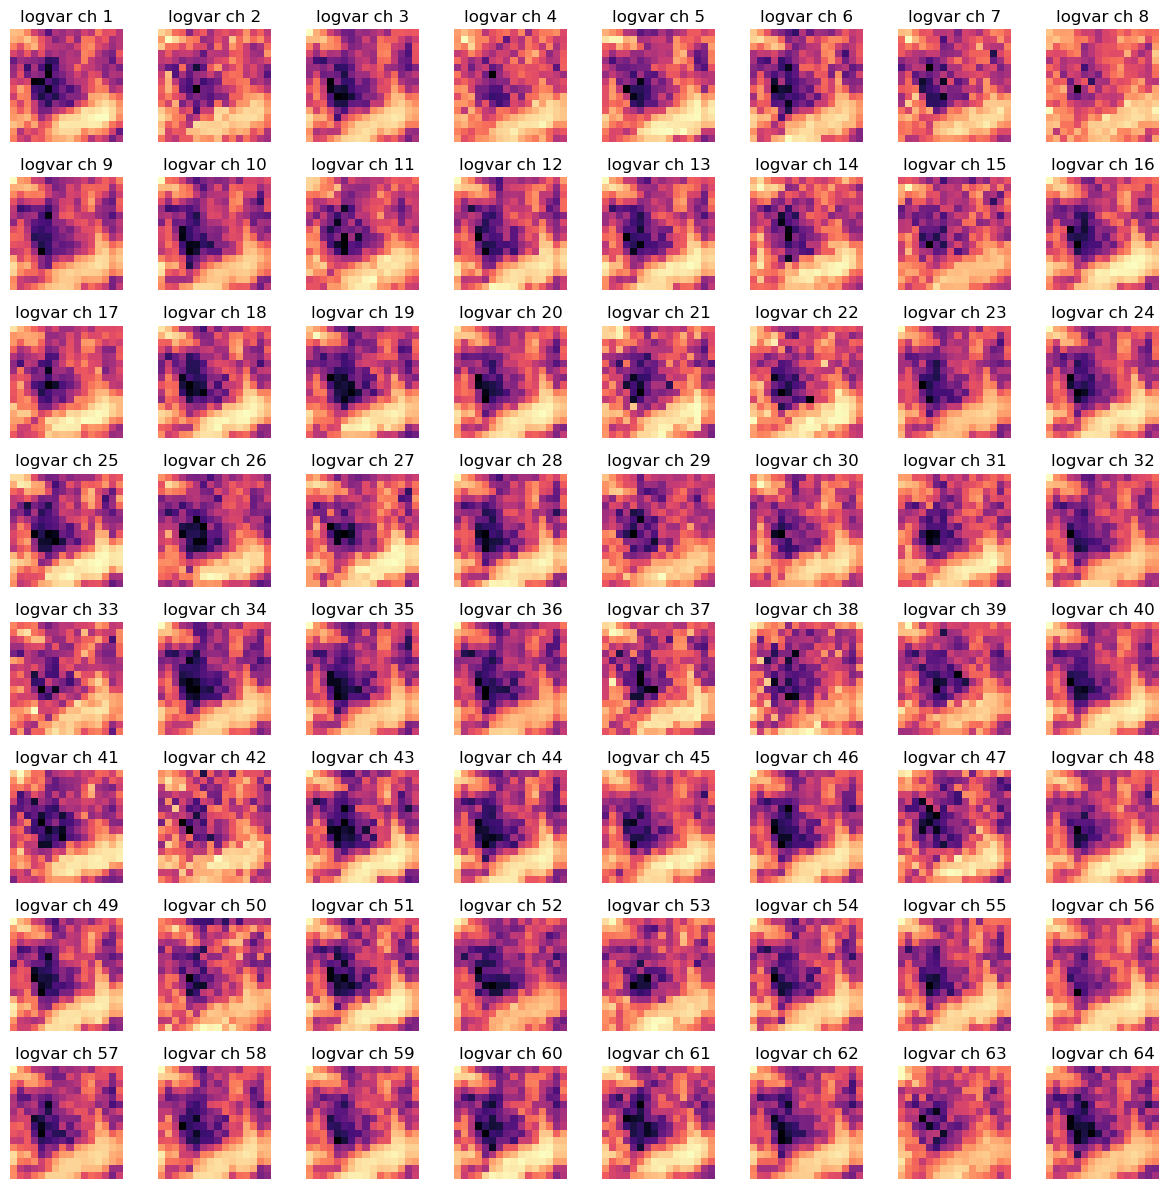

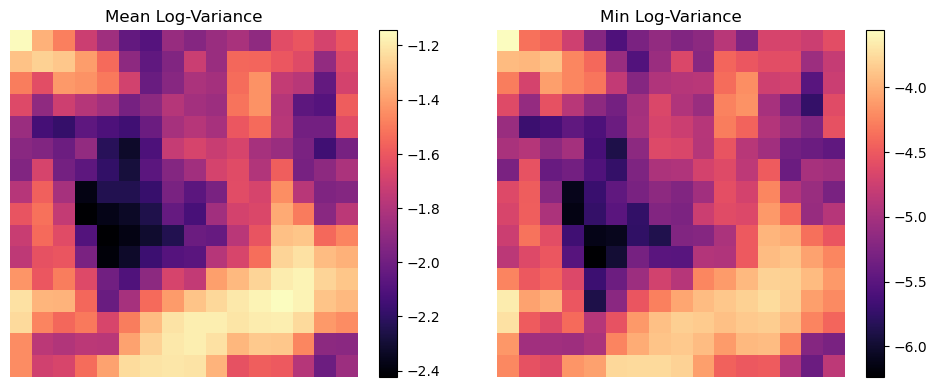

In [28]:
###################### Example Notebook Flow ######################
DEVICE = "mps"  # or "cpu"/"cuda"

# 1) Load your model
ckpt_path = "../../logs/2024-12-31T13-03-18_autoencoder_kl_8x8x64_jump_cuda/checkpoints/last.ckpt"
# ckpt_path = "../../logs/2024-12-31T13-04-28_autoencoder_kl_8x8x64_jump_cuda/checkpoints/epoch=000030.ckpt"
# ckpt_path = "../../logs/2024-12-31T13-53-14_autoencoder_kl_8x8x64_jump_cuda/checkpoints/epoch=000029.ckpt"
config_path = "../../configs/autoencoder/autoencoder_kl_8x8x64_jump_cuda.yaml"
model = load_vae_model(ckpt_path, config_path, device=DEVICE)

# 2) Load DataFrame
df = pd.read_parquet("data/subsets/subset_0.1percent.parquet")
print(f"Loaded {len(df)} rows.")

# 3) Pick a row, fetch + prep the image
row_index = 0
img_tensor, actual_channels = load_cellpainting_image_from_df(
    df, row_index, channels=["DNA", "ER", "RNA", "AGP", "Mito"]
)
img_tensor = img_tensor.to(DEVICE)

# 4) Reconstruct
with torch.no_grad():
    posterior = model.encode(img_tensor)
    latents = posterior.sample()
    recon = model.decode(latents)

# 5) Visualize real vs recon
real_chw = img_tensor[0]  # shape [C,H,W]
recon_chw = recon[0]
show_channels_side_by_side(real_chw, recon_chw, channel_names=actual_channels)

# 6) Visualize log-variance
visualize_logvar_full(model, img_tensor)